# 4. Implementing a GRU model

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (27/12/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- 

### Imports and CUDA

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, utils

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### The memory and GRU cell

The intuition behind the Gated Recurrent Unit (GRU) is to allow the model to selectively choose which information from the previous hidden state to retain and which to discard, in order to give more importance to recently predicted values for instance. It also helps to better handle the problem of vanishing gradients in RNNs. To do so, the GRU formula uses two gates, the update gate and the reset gate, to control the flow of information.

The update gate, represented by the equation 

$$ z_t = \sigma(W_z * x_t + U_z * h_{t-1} + b_z) $$

is used to decide what information to throw away from the previous hidden state, h_{t-1}. The value of $ z_t $ ranges between 0 and 1: a value of 0 means that the new hidden state will be entirely based on the new input, whereas a value of 1 means that the new hidden state will be entirely based on the previous hidden state.

The reset gate, represented by the equation

$$ r_t = \sigma(W_r * x_t + U_r * h_{t-1} + b_r) $$

is used to decide what information to keep from the previous hidden state. It also ranges between 0 and 1: a value of 0 means that the previous hidden state will be entirely discarded, whereas a value of 1 means that the previous hidden state will be entirely kept.

The new hidden state, h_t, is then computed by:

$$ h_t = (1-z_t) * h_{t-1} + z_t * \tilde{h_t} $$

Where

$$ \tilde{h_t} = tanh(W_h * x_t + U_h * (r_t * h_{t-1}) + b_h) $$

The new hidden state, $ h_t $, is a combination of the new input, $ x_t $, and the previous hidden state, $ h_{t-1} $, with the update gate, $ z_t $, and reset gate, $ r_t $, controlling the flow of information.

To recap, the diagram of a GRU cell is shown below.

...

Its implementation, in Numpy, is shown below.

In [3]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

class GRUCell:
    def __init__(self, input_size, hidden_size):
        # Sizes of weights and biases matrices
        # W_z : (input_size, hidden_size)
        # U_z : (hidden_size, hidden_size)
        # b_z : (hidden_size)

        # W_r : (input_size, hidden_size)
        # U_r : (hidden_size, hidden_size)
        # b_r : (hidden_size)

        # W_h : (input_size, hidden_size)
        # U_h : (hidden_size, hidden_size)
        # b_h : (hidden_size)
        self.W_z = np.random.randn(input_size, hidden_size)
        self.U_z = np.random.randn(hidden_size, hidden_size)
        self.b_z = np.random.randn(hidden_size)

        self.W_r = np.random.randn(input_size, hidden_size)
        self.U_r = np.random.randn(hidden_size, hidden_size)
        self.b_r = np.random.randn(hidden_size)

        self.W_h = np.random.randn(input_size, hidden_size)
        self.U_h = np.random.randn(hidden_size, hidden_size)
        self.b_h = np.random.randn(hidden_size)

    def forward(self, xt, h_tm1):
        z = sigmoid(np.dot(xt, self.W_z) + np.dot(h_tm1, self.U_z) + self.b_z)
        r = sigmoid(np.dot(xt, self.W_r) + np.dot(h_tm1, self.U_r) + self.b_r)
        h_hat = np.tanh(np.dot(xt, self.W_h) + np.dot(r*h_tm1, self.U_h) + self.b_h)
        h_next = (1 - z)*h_tm1 + z*h_hat
        return h_next

In [4]:
gru = GRUCell(3, 1)
input_data = np.random.randn(32, 3)
h_data = np.random.randn(32, 1)
h_next_data = gru.forward(input_data, h_data)
print("New hidden state size:", h_next_data.shape)

New hidden state size: (32, 1)


### A slightly better way to create our Dataset

As before, but using TensorDataset this time (to show you another way to create a dataset object from X and Y values)

In [13]:
# Define the dataset (as before)
np.random.seed(27)
x = np.linspace(0, 10, 1000)
y = np.sin(x) + 1e-2*(np.random.random(1000)-0.5)

# Convert numpy arrays to PyTorch tensors
x_train_torch = torch.from_numpy(x).float().view(-1, 1, 1)
y_train_torch = torch.from_numpy(y).float().view(-1, 1)

# Create the Tensor Dataset
train_dataset = TensorDataset(x_train_torch, y_train_torch)

# Create the DataLoader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

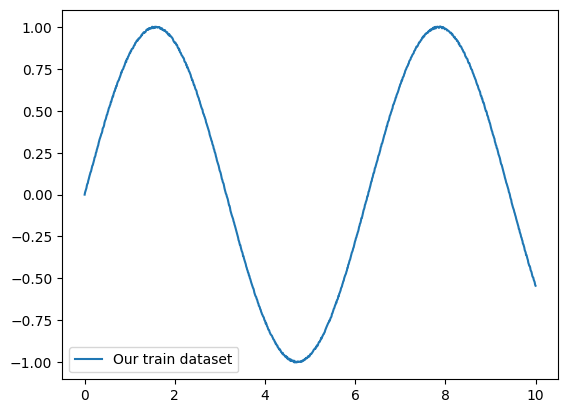

In [14]:
plt.plot(x, y, label = "Our train dataset")
plt.legend(loc = "best")
plt.show()

### Define a GRU model

...

In [15]:
# Define the GRU model
class GRU(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.gru = torch.nn.GRU(input_size, hidden_size, num_layers)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x, h_state):
        y, h_state = self.gru(x, h_state)
        z = self.fc(y[:, -1, :])
        return z, h_state

In [16]:
# Define the model parameters
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1

# Create the model
model = GRU(input_size, hidden_size, num_layers, output_size).to(device)
print(model)

GRU(
  (gru): GRU(1, 64)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


### Trainer

...

In [21]:
def train(model, train_dataloader, num_epochs, lr):
    # Define the loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    # Training loop
    for epoch in range(num_epochs):
        # Training loss initialize
        train_loss = 0
        # Loop through batches
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            # Initialize hidden state
            h_state = torch.zeros(num_layers, 1, hidden_size).to(device)
            # Forward pass
            outputs, h_state = model(inputs.to(device), h_state)
            loss = criterion(outputs, targets.to(device))
            train_loss += loss.item()
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
        
        # Compute final loss and display
        train_loss /= len(train_dataloader)
        print(f' Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}')
    
    # Return final hidden state
    return h_state

In [26]:
# Define the model parameters
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
torch.manual_seed(12)
model = GRU(input_size, hidden_size, num_layers, output_size).to(device)

# Train the model
num_epochs = 100
h_state = train(model, train_dataloader, num_epochs, lr = 1e-2)

 Epoch [1/100], Train Loss: 0.4715
 Epoch [2/100], Train Loss: 0.4353
 Epoch [3/100], Train Loss: 0.3754
 Epoch [4/100], Train Loss: 0.2290
 Epoch [5/100], Train Loss: 0.1576
 Epoch [6/100], Train Loss: 0.1539
 Epoch [7/100], Train Loss: 0.1064
 Epoch [8/100], Train Loss: 0.0746
 Epoch [9/100], Train Loss: 0.0620
 Epoch [10/100], Train Loss: 0.0322
 Epoch [11/100], Train Loss: 0.0197
 Epoch [12/100], Train Loss: 0.0299
 Epoch [13/100], Train Loss: 0.0225
 Epoch [14/100], Train Loss: 0.0095
 Epoch [15/100], Train Loss: 0.0079
 Epoch [16/100], Train Loss: 0.0073
 Epoch [17/100], Train Loss: 0.0036
 Epoch [18/100], Train Loss: 0.0086
 Epoch [19/100], Train Loss: 0.0143
 Epoch [20/100], Train Loss: 0.0071
 Epoch [21/100], Train Loss: 0.0052
 Epoch [22/100], Train Loss: 0.0042
 Epoch [23/100], Train Loss: 0.0053
 Epoch [24/100], Train Loss: 0.0026
 Epoch [25/100], Train Loss: 0.0032
 Epoch [26/100], Train Loss: 0.0025
 Epoch [27/100], Train Loss: 0.0057
 Epoch [28/100], Train Loss: 0.0077
 

### Evaluate model

...

In [27]:
def test_display(seed, dataloader, h_state, model, device):
    # Fetch a datapoint
    torch.manual_seed(seed)
    data = next(iter(train_dataloader))
    inputs_test = data[0]
    outputs_test = data[1]

    # Initialize hidden state and forward pass
    h_state.to(device)
    pred, h_state = model(inputs_test.to(device), h_state)
    pred_display = pred.detach().cpu()
    print(pred_display.shape)
    
    # Display
    plt.scatter(inputs_test[:, 0], outputs_test[:, 0], c = "r", label = "Targets")
    plt.scatter(inputs_test[:, 0], pred_display[:, 0], c = "g", marker = "x", label = "Predictions")
    plt.legend(loc = "best")
    plt.ylim(-1.05, 1.05)
    plt.show()

torch.Size([32, 1])


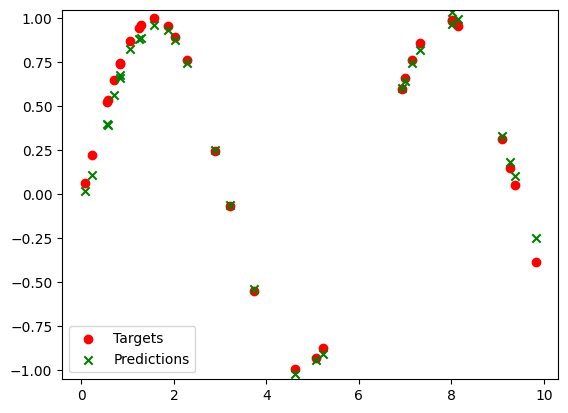

In [30]:
# Try it
test_display(seed = 5, dataloader = train_dataloader, h_state = h_state, model = model, device = device)

### What's next?

...